# 1. Importations

In [2]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings('ignore')
import random
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [4]:
path = 'https://fullstackds-projects-bucket.s3.eu-west-3.amazonaws.com/data/reviews_processed_with_spacy_md.csv'
df = pd.read_csv(path)
df.head()


# 2. Définition des fonctions

In [5]:
# Réduction du dataframe
col = ["firm","headline_clean","pros_clean","cons_clean"]
df_reduced = df[col].astype(str)
list_firms = df_reduced["firm"].unique()
print("Les entreprises présentes sont:")
for firm in list_firms:
    print(firm)
    # print()



Les entreprises présentes sont:
Apple
Deloitte
EY
IBM
J-P-Morgan
KPMG
McDonald-s
Microsoft
Oracle
PwC


In [7]:
# Creation des fonctions
   
def process_wordcloud(df, custom_stopwords={}):
    """
    Fonction calculant et retournant le nuage de mots.
    """
    stop_words = set(STOPWORDS)
    

    if custom_stopwords:
        if isinstance(custom_stopwords, list):
            stop_words.update(custom_stopwords) # Ajouter les mots à l'ensemble
        else: #Si ce n'est pas une liste, on suppose que c'est déjà un set.
            stop_words.update(custom_stopwords)

    # Generate word cloud
    wordcloud = WordCloud(max_words = 30, width=1000, height=600, background_color='white', stopwords=stop_words).generate(' '.join(df.fillna('').astype(str)))


    return wordcloud

def display_wordcloud(wordcloud, main_subject_title):
    """
    Fonction affichant le nuage de mots.
    """
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Frequent Words in {main_subject_title} Reviews', fontsize=16, pad=40)
    plt.show()

def most_common_words_identification(df, nb_words=30):
    """
    Fonction calculant et retournant les mots les plus fréquents.
    """
    # Combine all pros texts into a single string
    text = ' '.join(df)

    # Split to wordsand count frequency
    word_counts = Counter(text.split())

    # Nombre of words
    total_word = len(text.split())

    # Checking top-nb_words
    common_words = word_counts.most_common(nb_words)
    # for word, count in common_words:
    #     print(f"{word}: {count} ({count / total_word:.2%})")
    return common_words

def filtrage_ngrams(words_df, nb_topics=10):
    selected_n_grams = []
    covered_words = set() # Ensemble pour stocker les mots déjà "couverts"

    for index, row in words_df.iterrows():
        current_n_gram = row['term']
        current_n_gram_words = set(current_n_gram.split()) # Divise le n-gramme en mots individuels

        # Vérifie si le n-gramme actuel contient des mots déjà couverts
        is_redundant = False
        for word in current_n_gram_words:
            if word in covered_words:
                is_redundant = True
                break
        
        if not is_redundant:
            selected_n_grams.append(row['term']) # Ajoute le n-gramme à notre liste sélectionnée
            # Ajoute tous les mots de ce n-gramme à l'ensemble des mots couverts
            covered_words.update(current_n_gram_words)
        
        # Arrêtez une fois que nous avons suffisamment de n-grammes
        if len(selected_n_grams) >= nb_topics:
            break

    # Convertir la liste de dictionnaires en DataFrame
    # final_top_n_grams = pd.DataFrame(selected_n_grams)
    return selected_n_grams   

# Vectorize the pros column
def generate_vectorizer(df, n_gram_range=(1, 2), custom_stop_word={}):
    """
    Fonction pour générer le TF-IDF.
    """
    text = []

    stop_words = set(STOPWORDS) # Utilisez un ensemble pour une recherche plus rapide

    if custom_stop_word:
        if isinstance(custom_stop_word, list):
            stop_words.update(custom_stop_word) # Ajouter les mots à l'ensemble
        else: #Si ce n'est pas une liste, on suppose que c'est déjà un set.
            stop_words.update(custom_stop_word)

    for sentence in df:
        t = ' '.join([word for word in sentence.split() if word not in stop_words])
        text.append(t)

    vectorizer_TFIDF = TfidfVectorizer(max_features=1000, ngram_range=n_gram_range)
    vectorizer_Count = CountVectorizer(max_features=1000, ngram_range=n_gram_range, stop_words='english')
    
    X_Tfidf = vectorizer_TFIDF.fit_transform(text)
    X_Count = vectorizer_Count.fit_transform(text)
    return X_Tfidf, X_Count, vectorizer_TFIDF,vectorizer_Count

def display_top_topics(vectorizer, model, n_top_words=10):
    """
    Fonction pour afficher les topics les plus fréquents.
    """
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(model.components_):
        terms_in_topic = [terms[j] for j in comp.argsort()[:-(n_top_words+1):-1]]
        print(f"Topic {i+1}: {' | '.join(terms_in_topic)}")

# SVD decomposition
def svd_decomposition(X, n_components=2):
    """
    Fonction pour effectuer la décomposition tronquée SVD.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    # Fit the model and transform the data
    lsa = svd.fit(X)
    return lsa

def lda_decomposition(X,n_components=2):
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    return lda.fit(X)
 


# 3. Traitements

## 3.1 Wordcloud

In [8]:
# Common word for the whole dataset
def common_word_list(nb_top_words = 100):
    personal_word_tuple = []
    personal_word = ["jp", "morgan", "jpmorgan", "mc", "donald", "na"]
    for word in personal_word:
        personal_word_tuple.append((word.lower(),1))

    common_word_pros = most_common_words_identification(df_reduced["pros_clean"], nb_top_words)
    word_to_keep = ["benefit", "learn", "environment", "opportunity"]
    common_word_pros = [(mot, count) for mot, count in common_word_pros if mot not in word_to_keep]

    common_word_cons = most_common_words_identification(df_reduced["cons_clean"], nb_top_words)
    word_to_keep = ["management", "pay"]
    common_word_cons = [(mot, count) for mot, count in common_word_cons if mot not in word_to_keep]

    common_word_headline = most_common_words_identification(df_reduced["headline_clean"], nb_top_words)
    word_to_keep = ["experience", "manager", "career"]
    common_word_headline = [(mot, count) for mot, count in common_word_headline if mot not in word_to_keep]

    common_word = common_word_pros+common_word_cons+common_word_headline + personal_word_tuple

    return common_word

common_word = common_word_list(nb_top_words = 30)




Firm: Apple

PROS


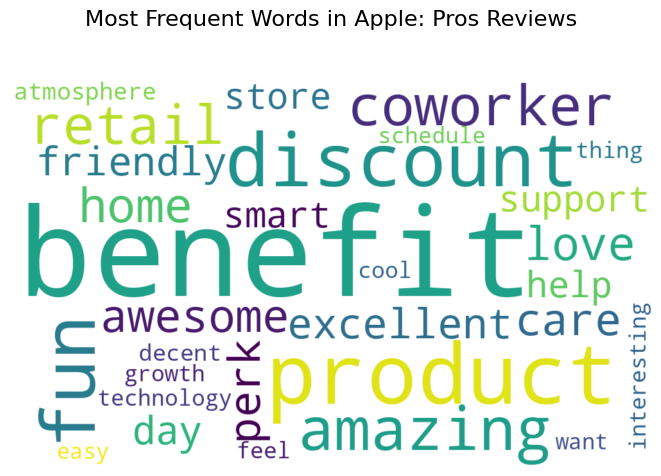


CONS


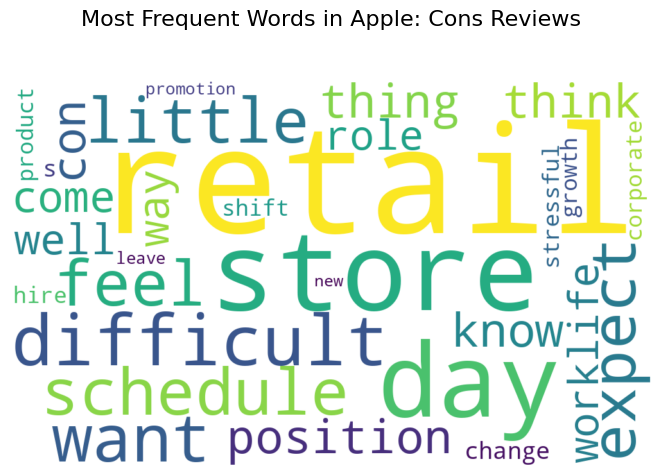


HEADLINE


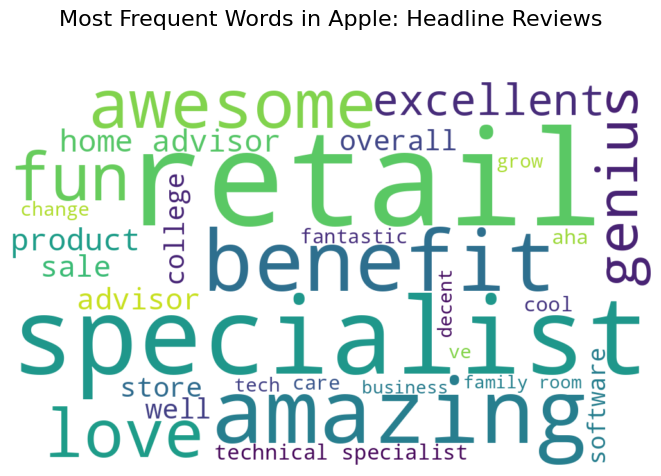


Firm: Deloitte

PROS


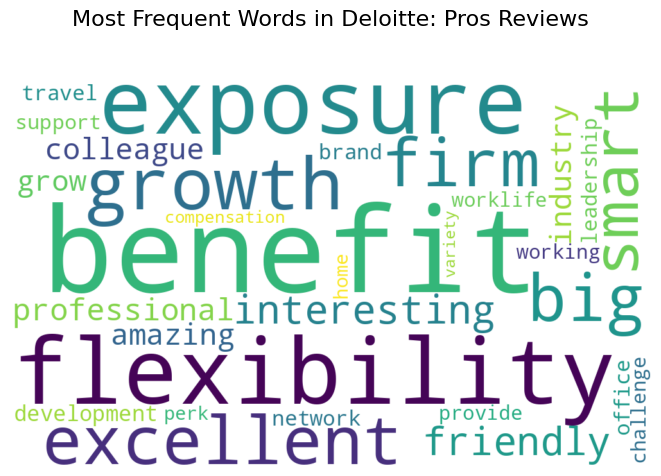


CONS


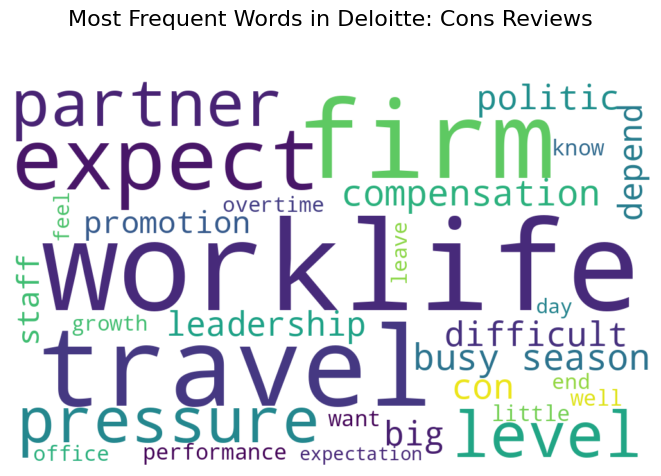


HEADLINE


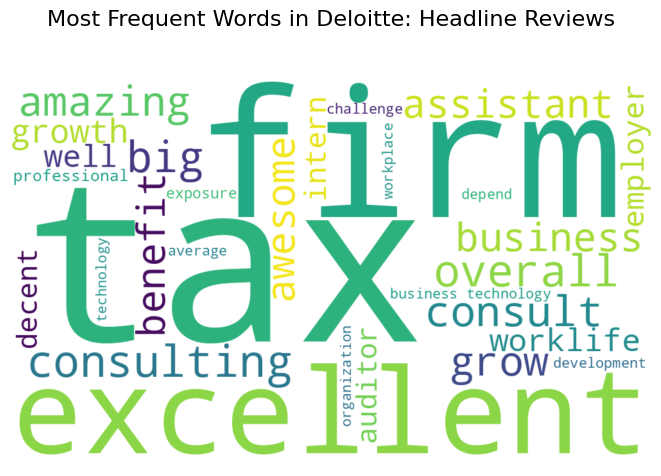


Firm: EY

PROS


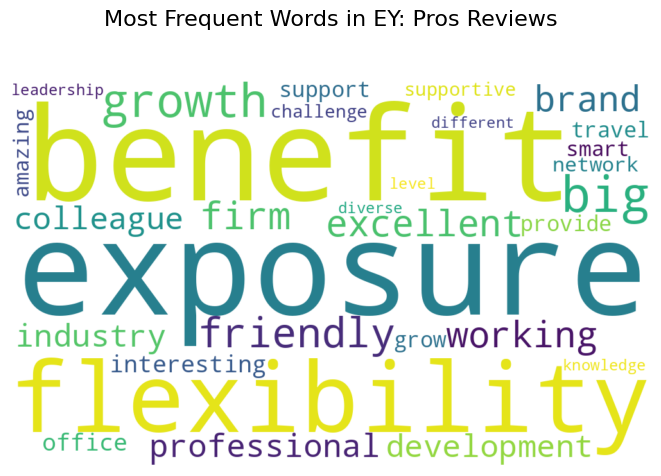


CONS


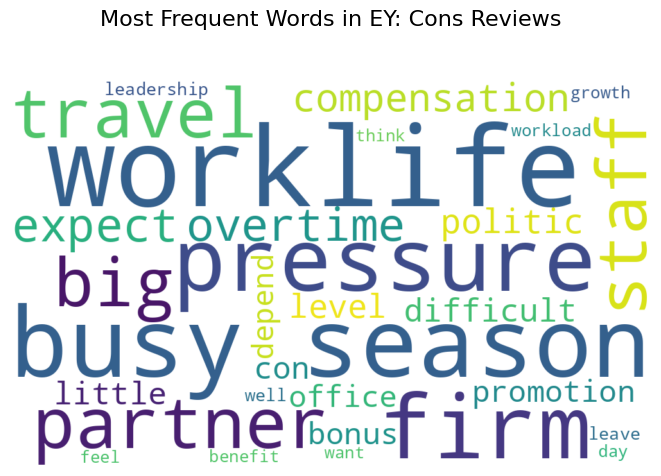


HEADLINE


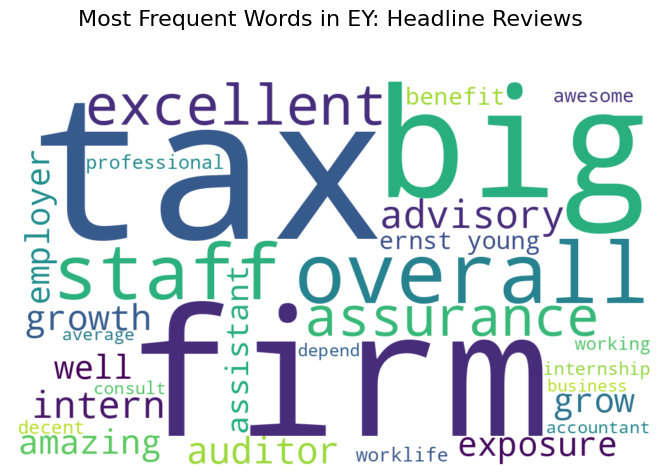


Firm: IBM

PROS


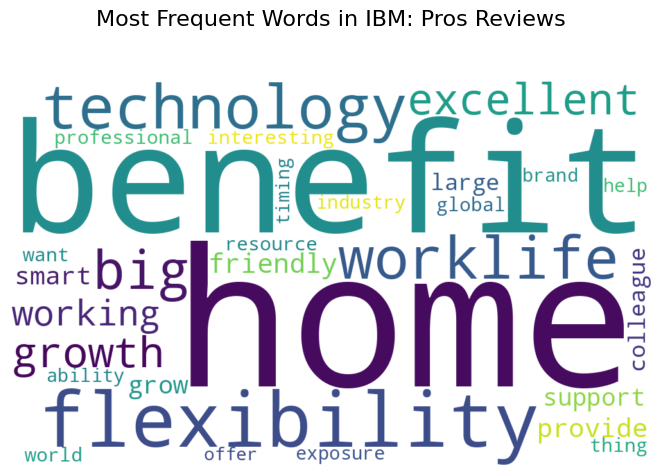


CONS


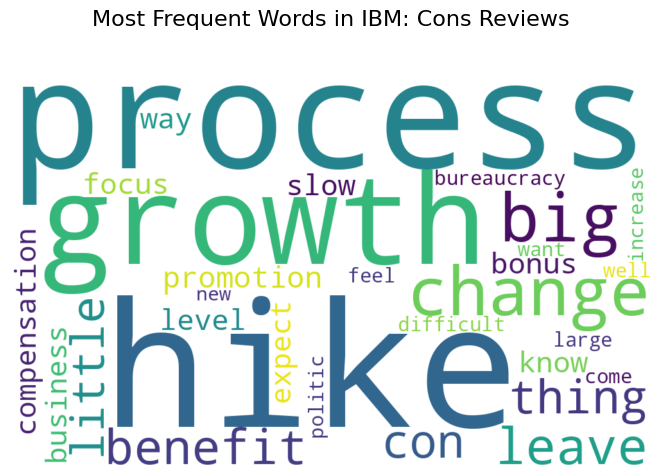


HEADLINE


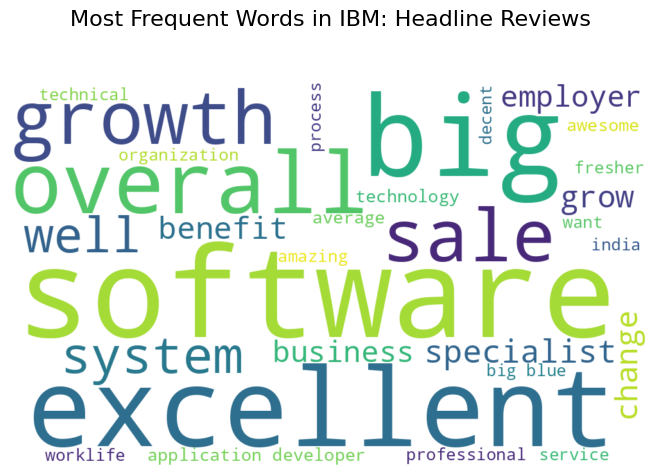


Firm: J-P-Morgan

PROS


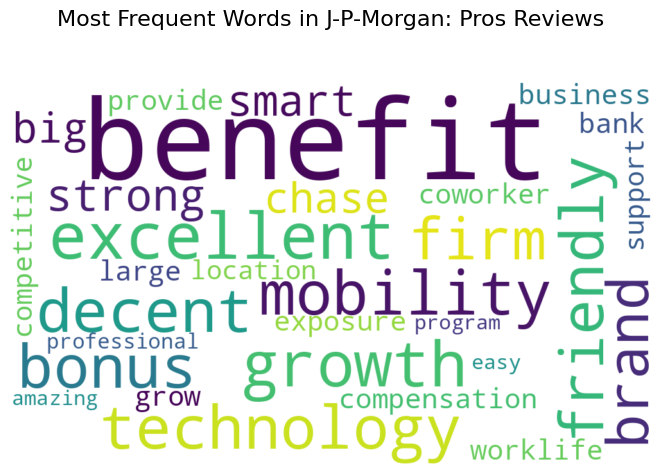


CONS


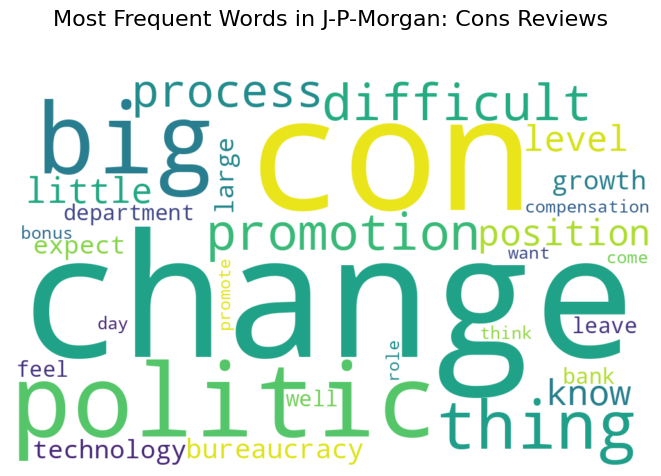


HEADLINE


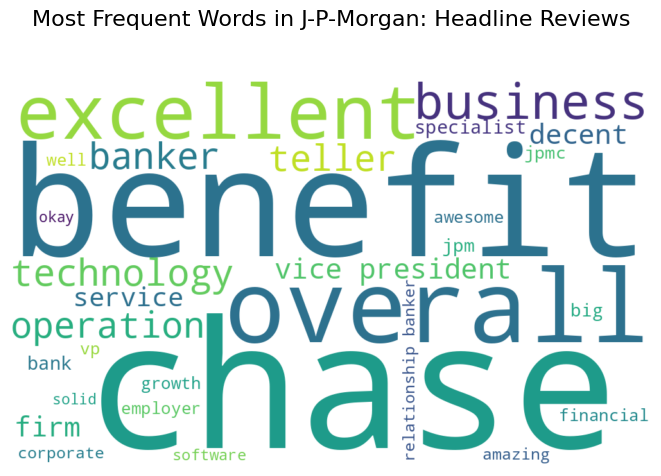


Firm: KPMG

PROS


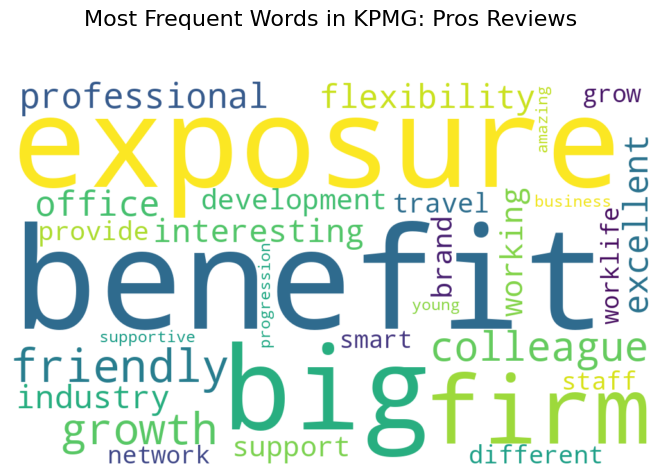


CONS


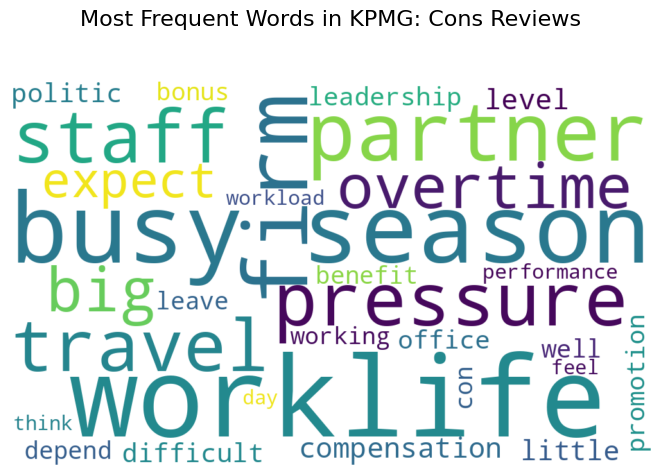


HEADLINE


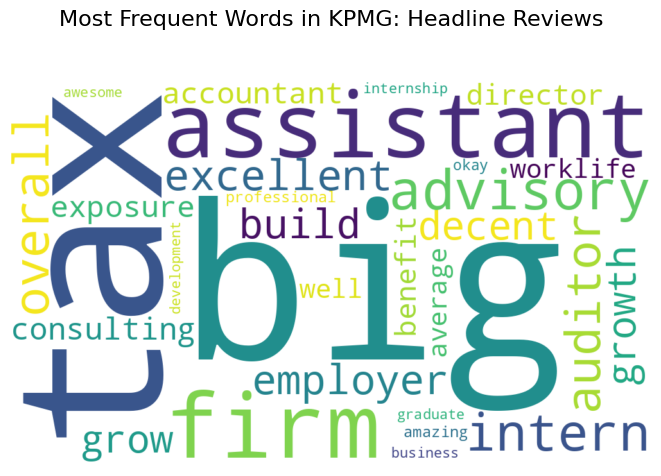


Firm: McDonald-s

PROS


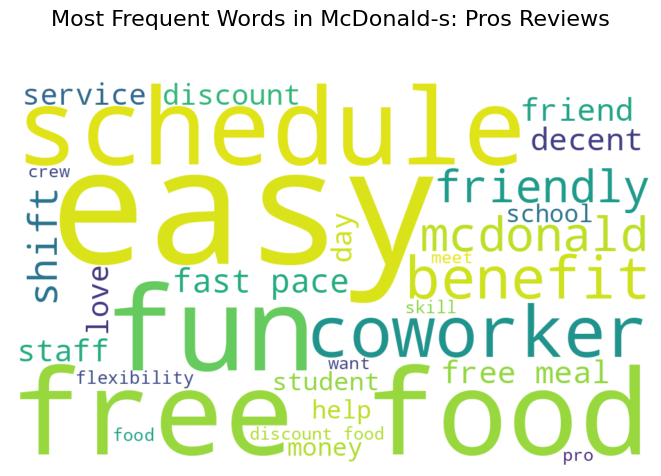


CONS


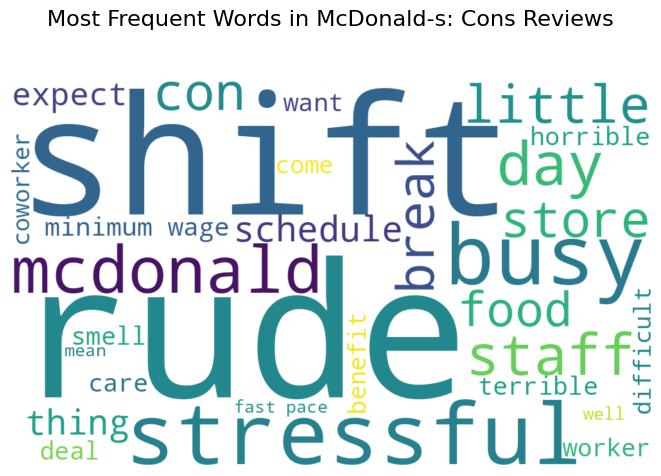


HEADLINE


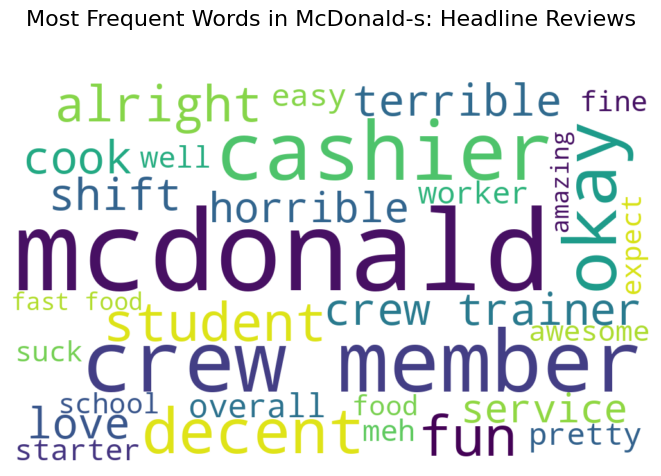


Firm: Microsoft

PROS


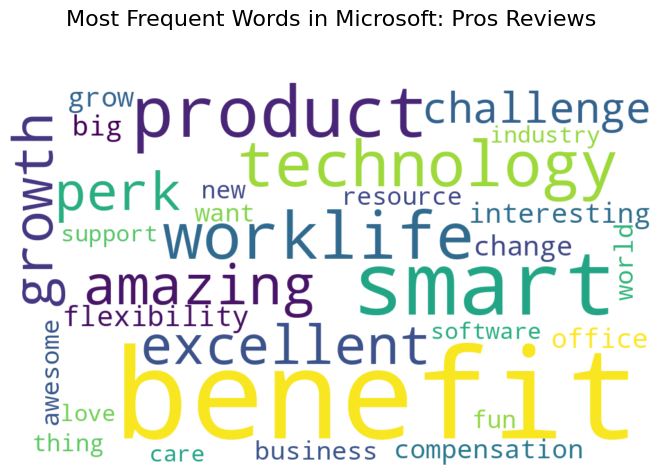


CONS


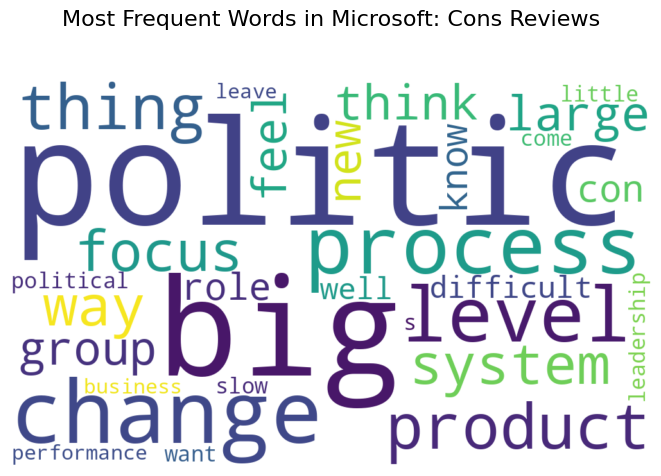


HEADLINE


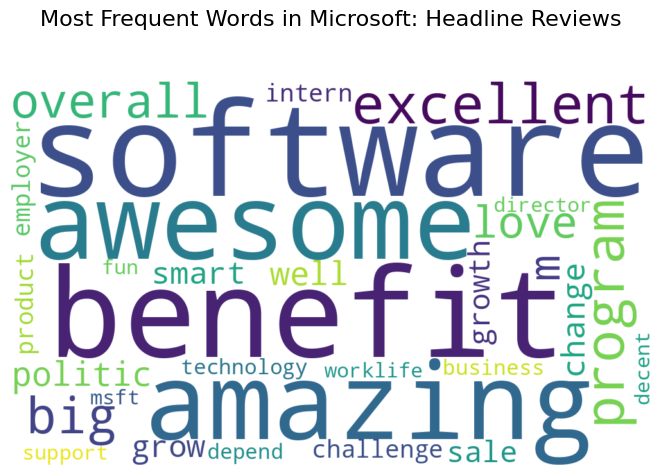


Firm: Oracle

PROS


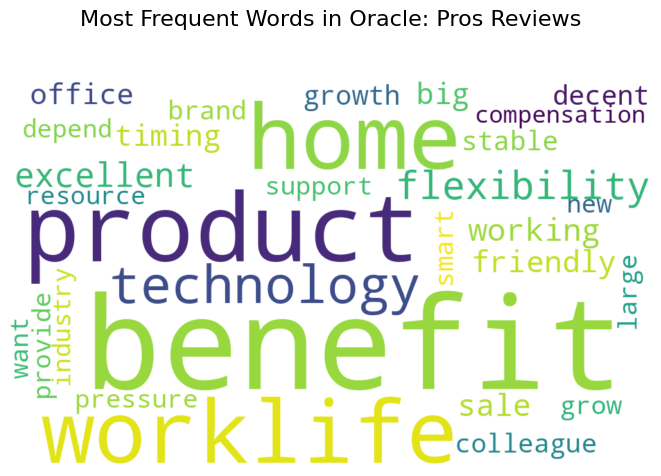


CONS


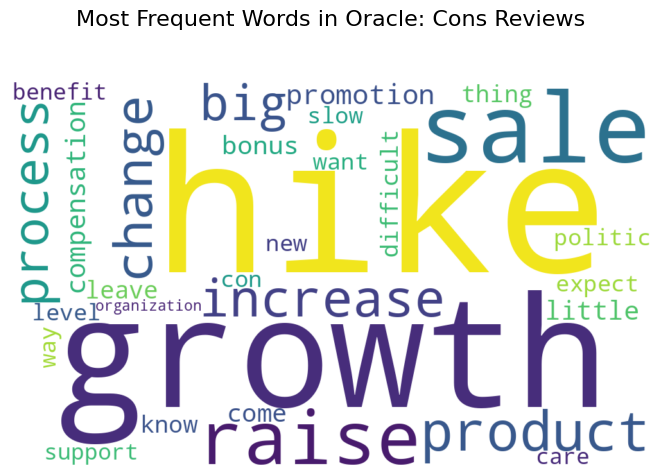


HEADLINE


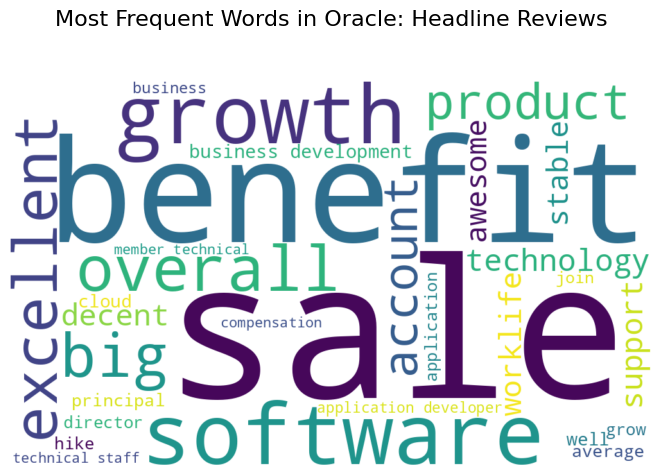


Firm: PwC

PROS


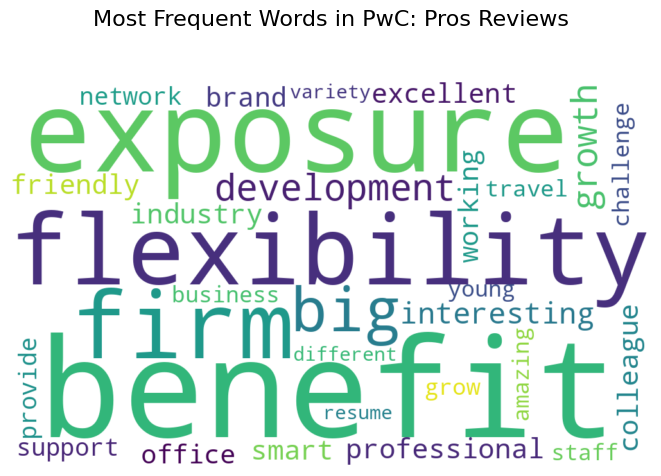


CONS


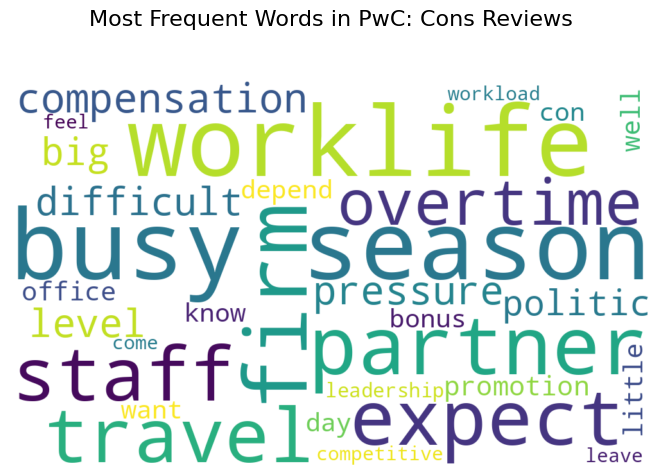


HEADLINE


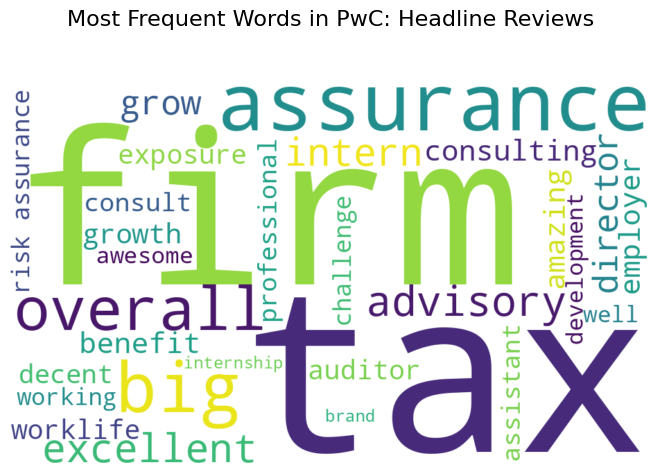

In [9]:
# Affichage des wordclouds
for firm in list_firms:
  df_firm = df_reduced[df_reduced["firm"] == firm].astype(str)
  print(f"Firm: {firm}\n")

  for c in ["pros","cons","headline"]:
      print(c.upper())
      custom_stop_word = {firm.lower()}
      custom_stop_word.update({word for word,count in common_word})
      if c == "pros":
         col = "pros_clean"
      if c == "cons":
         col = "cons_clean"
      if c == "headline":
         col = "headline_clean"

            
      # WORDCLOUD
      wd = process_wordcloud(df_firm[f"{col}"], custom_stopwords=custom_stop_word)    
      if c == "headline":
        display_wordcloud(wd, f"{firm}: Headline")
      elif c == "pros":
        display_wordcloud(wd, f"{firm}: Pros")
      elif c == "cons":
        display_wordcloud(wd, f"{firm}: Cons")
      print()


## 3.2 Topics

In [10]:
#  Affichage des topics
for firm in list_firms:
  df_firm = df_reduced[df_reduced["firm"] == firm].astype(str)
  print(f"Firm: {firm}\n")
  custom_stop_word = {firm.lower()}  

#   for c in ["pros"]:
  for c in ["pros","cons"]:
      print(c.upper())
      
      custom_stop_word.update({word for word,count in common_word})
      if c == "pros":
         col = "pros_clean"
      if c == "cons":
         col = "cons_clean"
      if c == "headline":
         col = "headline_clean"

      # TOPICS
      # Generate TF-IDF matrix
      X_Tfidf ,X_Count, vectorizer_TFIDF, vectorizer_Count = generate_vectorizer(df_firm[f"{col}"],
                                                                               n_gram_range=(2, 3),
                                                                               custom_stop_word=custom_stop_word)
      
      nb_topics = 3

      # # Separer topic modeling
      # # Perform LSA
      # lsa = svd_decomposition(X_Tfidf, n_components=nb_topics)
      # # Display top topics
      # print(f"Top topics from LSA for {firm} in {c}:")
      # print(len(df_firm))
      # display_top_topics(vectorizer_TFIDF, lsa, n_top_words=3)
      # print()

      # # Perform LDA
      # lda = lda_decomposition(X_Count, n_components=nb_topics)
      # print(f"Top topics from LDA for {firm} in {c}:")
      # display_top_topics(vectorizer_Count, lda, n_top_words=5)
      # print()

      feature_names = vectorizer_Count.get_feature_names_out()
      word_counts = np.asarray(X_Count.sum(axis=0)).flatten() # Convertir la matrice somme en un array 1D

      # Créer un DataFrame Pandas pour faciliter le tri
      words_df = pd.DataFrame({'term': feature_names, 'count': word_counts})

      # 3.3. Trier par fréquence et sélectionner le top 3
      top_words = words_df.sort_values(by='count', ascending=False).reset_index()
      top_words = top_words.drop('index', axis=1)
      top_words_filtered = filtrage_ngrams(top_words,nb_topics = 3)
      print("\n--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---")
      for index, word in enumerate(top_words_filtered):
         sentence = f"{index+1}. {word.capitalize()}"
         print(sentence)
      print("*********************")  

Firm: Apple

PROS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Discount product
2. Amazing benefit
3. Stock option
*********************
CONS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Retail store
2. Fast pace
3. Room growth
*********************
Firm: Deloitte

PROS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Different industry
2. Fast pace
3. Professional development
*********************
CONS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Busy season
2. Firm initiative
3. Service line
*********************
Firm: EY

PROS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Exposure different
2. Steep curve
3. Fast pace
*********************
CONS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. Busy season
2. Office politic
3. Service line
*********************
Firm: IBM

PROS

--- Top 3 des mots/n-grammes les plus utilisés dans le corpus ---
1. 